# Correspondence Analysis Step by Step

The actual script encompasses an application of the *Correspondence Analysis* technique step by step and checking if the outputs matches results gotten by the [prince](https://pypi.org/project/prince/) library.

## Step by step implementation

The database used in the implementation concerns a group of people separated by their investment profile and the type of investment they carry out. There are three types of investment profile ('Agressivo', 'Conservador', 'Moderado') and three types of investments ('Ações', 'Poupança', 'CDB').

The algorithm aims on:

  - Checking if there are any correspondence pattern between these two groups of variables (both categorical);
  
  
  - Which pair of variables are most commomly associated;
  
  
  - Plotting a *Perceptual Map* considering the two groups.


### Checking the Dataset

The first step is transforming the data into a *Contingency Table*.

In [212]:
# Libraries needed
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy
import math
import prince
sns.set()

In [213]:
# Loading Dataset
data = pd.read_excel('aplicacao_perfil.xlsx')

In [214]:
# Checking Dataset
data.head(15)

,ID,Perfil,Tipo de Aplicação
0,1,Conservador,Poupança
1,2,Conservador,Poupança
2,3,Conservador,Poupança
3,4,Conservador,Poupança
4,5,Conservador,Poupança
5,6,Conservador,Poupança
6,7,Conservador,Poupança
7,8,Conservador,Poupança
8,9,Conservador,CDB
9,10,Conservador,CDB


In [215]:
# Contingency table
contingency_table = data[['Perfil', 'Tipo de Aplicação']].value_counts().reset_index().pivot(index=['Perfil'], columns=['Tipo de Aplicação'])[0].fillna(0)
contingency_table = contingency_table[['Poupança', 'CDB', 'Ações']].loc[['Conservador', 'Moderado', 'Agressivo']]
contingency_table

Tipo de Aplicação,Poupança,CDB,Ações
Perfil,,,
Conservador,8,4,5
Moderado,5,16,4
Agressivo,2,20,36


Once the raw data was turned into a contingency table, the next step is using the *Chi-Square Test for Association* that will determine if there is any association between two groups.

### Chi-Square Test for Association

The [scipy](https://docs.scipy.org/) library contains a fuction that could help with the test, but once the script is a step by step implementation, the function will be used just for checking the results.

(significance level considered: 5%)

In [216]:
# Applying chi2_contingency function
stat, pval, dof, expected = scipy.stats.chi2_contingency(contingency_table)
if pval < 0.05:
    print('H0 rejected, the variables are associated.')
else:
    print('H0 accepted, the variables are not associated.')

H0 rejected, the variables are associated.


In [217]:
# Expected table
expected_table = pd.DataFrame(index = contingency_table.index, columns = contingency_table.columns)
for i in expected_table.index:
    for j in expected_table.columns:
        expected_table[j].loc[i] = (contingency_table.loc[i].sum() * contingency_table[j].sum())/contingency_table.sum().sum()
expected_table      

Tipo de Aplicação,Poupança,CDB,Ações
Perfil,,,
Conservador,2.55,6.8,7.65
Moderado,3.75,10.0,11.25
Agressivo,8.7,23.2,26.1


In [218]:
# Residual table
residual_table = contingency_table - expected_table
residual_table

Tipo de Aplicação,Poupança,CDB,Ações
Perfil,,,
Conservador,5.45,-2.8,-2.65
Moderado,1.25,6.0,-7.25
Agressivo,-6.7,-3.2,9.9


In [219]:
# Chi-Square table
chi2_table = (residual_table**2)/expected_table
chi2_table

Tipo de Aplicação,Poupança,CDB,Ações
Perfil,,,
Conservador,11.648039,1.152941,0.917974
Moderado,0.416667,3.6,4.672222
Agressivo,5.15977,0.441379,3.755172


In [220]:
# Comparing calculated results to the chi2_contingency function

# Statistic
stat_f = chi2_table.sum().sum()
stat_f

# Degrees of Freedom
dof_f = (len(contingency_table.columns)-1)*(len(contingency_table.index)-1)

# P value
pval_f = 1 - scipy.stats.chi2.cdf(stat_f, dof_f)
pval_f

# Comparing
print(pval, pval_f)
print(stat, stat_f)
print(dof, dof_f)

2.137594051381398e-06 2.1375940514323233e-06
31.764164976335362 31.76416497633536
4 4


There is association between the variables.

### Standardized (and Adjusted Standardized) Residuals Table

The adjusted standardized residuals allows deepening the analysis focusing on the specific categories among the variables.

In [221]:
# Standardized Residual table
st_residual_table = residual_table/(expected_table**(1/2))
st_residual_table

Tipo de Aplicação,Poupança,CDB,Ações
Perfil,,,
Conservador,3.412922,-1.073751,-0.95811
Moderado,0.645497,1.897367,-2.161532
Agressivo,-2.271513,-0.664364,1.937827


In [222]:
# Adjusted Standardized Residual table
ad_st_residual_table = pd.DataFrame(index = st_residual_table.index, columns = st_residual_table.columns)
for i in st_residual_table.index:
    for j in st_residual_table.columns:
        ad_st_residual_table[j].loc[i] =  st_residual_table[j].loc[i] / ((1 - (contingency_table.loc[i].sum()/contingency_table.sum().sum())) * (1 - (contingency_table[j].sum()/contingency_table.sum().sum())))**(1/2)
ad_st_residual_table      

Tipo de Aplicação,Poupança,CDB,Ações
Perfil,,,
Conservador,4.063291,-1.521559,-1.418061
Moderado,0.808452,2.828427,-3.365501
Agressivo,-3.801728,-1.323444,4.031893


If the cell's value on the table is bigger than 1.96 there's significant association between the row and column categories.

In [223]:
# Interpreting
def red(val):
    color = 'red' if val > 1.96 else 'black'
    return 'color: %s' % color

ad_st_residual_table.style.applymap(red)

Tipo de Aplicação,Poupança,CDB,Ações
Perfil,,,
Conservador,4.063291,-1.521559,-1.418061
Moderado,0.808452,2.828427,-3.365501
Agressivo,-3.801728,-1.323444,4.031893


As it can be checked, there are some significant significant association between 'Conservador' and 'Poupança', 'Moderado' and 'CDB', 'Agressivo' and 'Ações'.

### Eigenvalues

In order to proceed with the analysis eigenvalues need to be found and intepreted.

It's also important to point that the Perceptual Map - helps to visualize the associations between the categories over the different variables - it can have more than two dimensions, the number is the minimum of row categories minus 1 or column categories minus 1, whichever is less.


In [224]:
# A Matrix
matrix_a = np.array(st_residual_table/contingency_table.sum().sum()**(1/2))
matrix_a

array([[0.34129223864140645, -0.10737509843863184, -0.0958109522032398],
       [0.06454972243679027, 0.18973665961010275, -0.21615323782497967],
       [-0.2271512737129715, -0.06643638388299196, 0.19378267243985212]],
      dtype=object)

In [225]:
# W Matrix
matrix_w = np.dot(matrix_a.T,matrix_a)
matrix_w

array([[0.1722447599729547, -0.00930772978664061, -0.09067014673744041],
       [-0.00930772978664061, 0.05194320486815415, -0.04359870290058393],
       [-0.09067014673744041, -0.04359870290058393, 0.09345368492224475]],
      dtype=object)

In [226]:
ndim = min(contingency_table.shape) - 1

# Eigenvalues
vals, vecs = np.linalg.eig(matrix_w. astype(float))
vals = vals[0:ndim]
vals

array([0.23321487, 0.08442678])

In [227]:
# Eigenvalues DataFrame
df_eigenvalues = pd.DataFrame(index=[1,2], columns = ['Eigenvalue', '% TPI', 'Single Value'])
df_eigenvalues['Eigenvalue'] = vals
df_eigenvalues['% TPI'] = vals/vals.sum()
df_eigenvalues['Single Value'] = vals**(1/2)
df_eigenvalues

,Eigenvalue,% TPI,Single Value
1,0.233215,0.734207,0.482923
2,0.084427,0.265793,0.290563


The '% TPI' column represents the percentage of the Total Principal Inertia, a (for each column) greater the total principal inertia inticates a stronger association between the variables in analysis on that dimension.

### Row and Column Masses

In the terminology of correspondence analysis, the row and column totals of the matrix of relative frequencies are called the row mass and column mass, respectively. Two diagonal matrixes (for rows and columns), containing the masses on their main diagonal and zeros out of it.

In [228]:
# Row masses
row_masses = contingency_table.sum(1)/contingency_table.sum().sum()
row_masses

Perfil
Conservador    0.17
Moderado       0.25
Agressivo      0.58
dtype: float64

In [229]:
# Rows Diagonal Matrix
diag_matrix_row = pd.DataFrame(np.identity(3))
for i in diag_matrix_row.index:
    diag_matrix_row.loc[i] = diag_matrix_row.loc[i] * row_masses[i]
diag_matrix_row

,0,1,2
0,0.17,0.00,0.00
1,0.00,0.25,0.00
2,0.00,0.00,0.58


In [230]:
# Column masses
column_masses = contingency_table.sum()/contingency_table.sum().sum()
column_masses

Tipo de Aplicação
Poupança    0.15
CDB         0.40
Ações       0.45
dtype: float64

In [231]:
# Cols Diagonal Matrix 
diag_matrix_col = pd.DataFrame(np.identity(3))
for i in diag_matrix_col.index:
    diag_matrix_col.loc[i] = diag_matrix_col.loc[i] * column_masses[i]
diag_matrix_col

,0,1,2
0,0.15,0.0,0.00
1,0.00,0.4,0.00
2,0.00,0.0,0.45


### Eigenvectors

In order to find the Perceptual Map coordinates the eigenvectors of the column (V) and the eigenvectors of the row (U) - forr both dimensions - are needed, and for this row and column masses and the eigenvalues will be used.

In [232]:
# 1 Dimension Matrix
dim1_matrix = (np.identity(3)*df_eigenvalues['Eigenvalue'].loc[1]) - matrix_w
dim1_matrix

array([[0.06097011285288381, 0.00930772978664061, 0.09067014673744041],
       [0.00930772978664061, 0.18127166795768435, 0.04359870290058393],
       [0.09067014673744041, 0.04359870290058393, 0.13976118790359376]],
      dtype=object)

In [233]:
# V1 eigenvector
v1 = scipy.linalg.null_space(dim1_matrix.astype(float))
v1

array([[ 0.82178847],
       [ 0.09300977],
       [-0.56215025]])

In [234]:
# U1 eigenvector
u1 = np.dot(matrix_a, v1/df_eigenvalues['Single Value'].loc[1])
u1

array([[0.671624811912404],
       [0.3980014914834623],
       [-0.6249119336359065]], dtype=object)

In [235]:
# 2 Dimension Matrix
dim2_matrix = (np.identity(3)*df_eigenvalues['Eigenvalue'].loc[2]) - matrix_w
dim2_matrix

array([[-0.08781798303543957, 0.00930772978664061, 0.09067014673744041],
       [0.00930772978664061, 0.032483572069360964, 0.04359870290058393],
       [0.09067014673744041, 0.04359870290058393, -0.009026907984729632]],
      dtype=object)

In [236]:
# V2 eigenvector
v2 = scipy.linalg.null_space(dim2_matrix.astype(float))
v2

array([[ 0.41792789],
       [-0.76899232],
       [ 0.48372213]])

In [237]:
# U2 eigenvector
u2 = np.dot(matrix_a, v2/df_eigenvalues['Single Value'].loc[2])
u2

array([[0.6155648723113007],
       [-0.7691520088883205],
       [0.17171218710223343]], dtype=object)

### Map's Coordinates

Once the Diagonal Matrixes and the Eigenvectors were found, the next step is determinating the categories's codinates.


For categories in the contingency table's rows:


 - Abcissas(X): Xrow = √eigenval1. DiagMatrixRow-1/2 . u1
 
 - Ordinates(Y): Yrow = √eigenval2. DiagMatrixRow-1/2 . u2



For categories in the contingency table's columns:
 
 - Abcissas(x): Xcol = √eigenval1. DiagMatrixCol-1/2 . v1
 
 - Ordinates(Y): Ycol = √eigenval2. DiagMatrixCol-1/2 . v2

In [238]:
# X Row
Xrow = np.dot(((df_eigenvalues['Single Value'].loc[1]**(1/2))/(diag_matrix_row**(1/2))).replace([np.inf, -np.inf],0), u1)
Xrow

array([[1.1319867204159946],
       [0.5531638059383607],
       [-0.5702218861298436]], dtype=object)

In [239]:
# Y Row
Yrow = np.dot(((df_eigenvalues['Single Value'].loc[2]**(1/2))/(diag_matrix_row**(1/2))).replace([np.inf, -np.inf],0), u2)
Yrow

array([[0.8047656302076793],
       [-0.829205600829271],
       [0.12153662598622798]], dtype=object)

In [240]:
# X Col
Xcol = np.dot(((df_eigenvalues['Single Value'].loc[1]**(1/2))/(diag_matrix_col**(1/2))).replace([np.inf, -np.inf],0), v1)
Xcol

array([[ 1.47452952],
       [ 0.10219688],
       [-0.58235151]])

In [241]:
# Y Col
Ycol = np.dot(((df_eigenvalues['Single Value'].loc[2]**(1/2))/(diag_matrix_col**(1/2))).replace([np.inf, -np.inf],0), v2)
Ycol

array([[ 0.5816688 ],
       [-0.65540848],
       [ 0.38869572]])

In [242]:
# Coordinates
df_coordinates = pd.DataFrame(index = list(row_masses.index) + list(column_masses.index), columns = ['X', 'Y'])
df_coordinates['X'].loc[list(row_masses.index)] = Xrow.reshape(3)
df_coordinates['Y'].loc[list(row_masses.index)] = Yrow.reshape(3)
df_coordinates['X'].loc[list(column_masses.index)] = Xcol.reshape(3)
df_coordinates['Y'].loc[list(column_masses.index)] = Ycol.reshape(3)
df_coordinates

,X,Y
Conservador,1.131987,0.804766
Moderado,0.553164,-0.829206
Agressivo,-0.570222,0.121537
Poupança,1.47453,0.581669
CDB,0.102197,-0.655408
Ações,-0.582352,0.388696


### Plotting and Interpreting the Perceptual Map

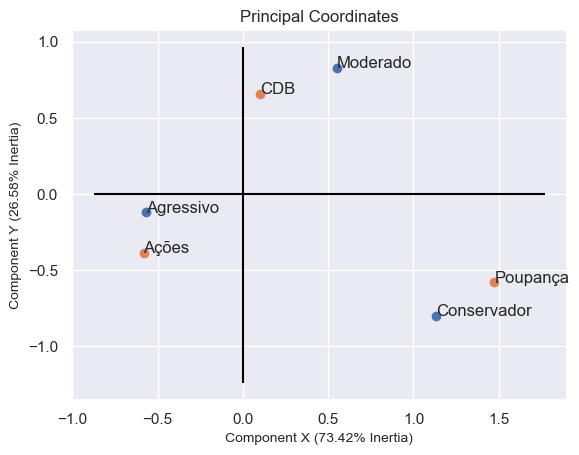

In [262]:
plt.scatter(df_coordinates['X'].loc[row_masses.index], df_coordinates['Y'].loc[row_masses.index]*-1)
plt.scatter(df_coordinates['X'].loc[column_masses.index], df_coordinates['Y'].loc[column_masses.index]*-1)
plt.hlines(0, df_coordinates['X'].max()*1.2, df_coordinates['X'].min()*1.5, color='black')
plt.vlines(0, df_coordinates['Y'].max()*1.2, df_coordinates['Y'].min()*1.5, color='black')
for i in df_coordinates.index:
    plt.text(df_coordinates['X'].loc[i], df_coordinates['Y'].loc[i]*-1, i)
plt.title('Principal Coordinates')
plt.xlabel(f'Component X ({round((df_eigenvalues["% TPI"].loc[1]*100),2)}% Inertia)', size=10)
plt.ylabel(f'Component Y ({round((df_eigenvalues["% TPI"].loc[2]*100),2)}% Inertia)', size=10)
plt.show()

### COmparação

In [257]:
# Num. de dimensões
ndim = (np.array(contingency_table.shape) - 1).min()
# Criando o modelo ANACOR
ca = prince.CA(n_components=ndim)
ca.fit(contingency_table);

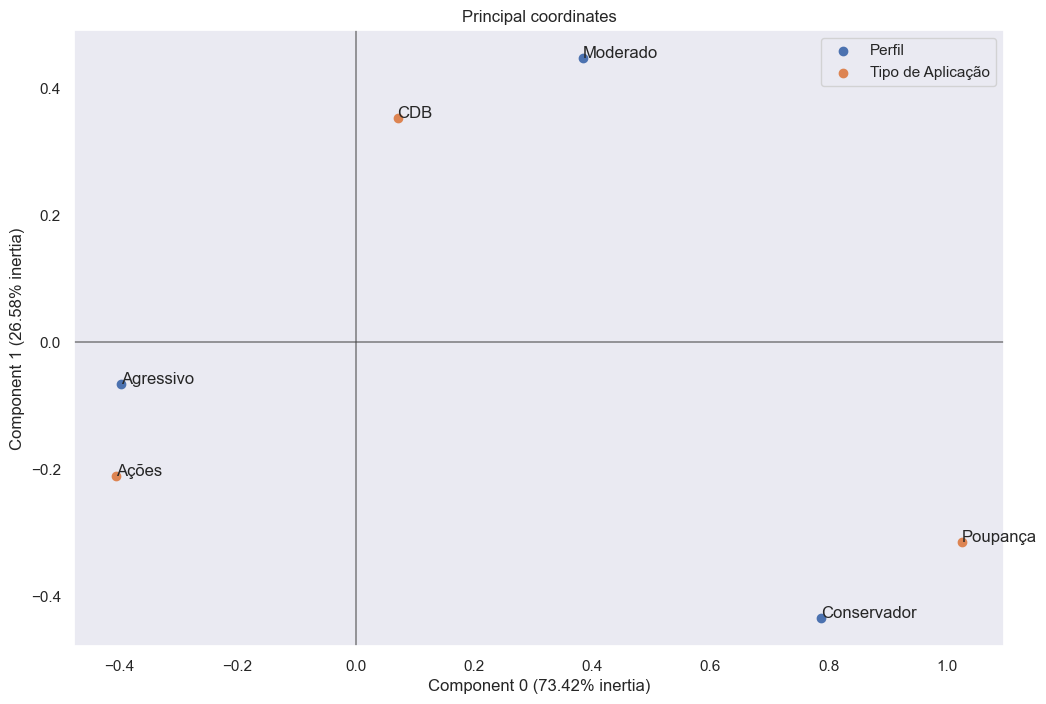

In [258]:
ca.plot_coordinates(contingency_table, figsize=(12, 8))
plt.show()